## 第十週：主題模型（中文）
Last modified: 讀書會第一組W10（2024/05/6） <br>

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以中文文本為示範。<br>
<br>
這次課程分為7個部分：
1. 介紹使用到的套件
2. 將資料進行前處理
3. lexicon-based 的主題模型
4. LDA 主題模型
5. 視覺化主題模型
6. GuidedLDA
7. 主題模型的應用

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.5 MB/s eta 0:00:00


In [ ]:
import time
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 設定中文字體
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2. 資料前處理

In [119]:
udn = pd.read_csv("week10data.csv", encoding='utf-8')  # 匯資料
udn.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/home-sale/M.1709223923....,[請益]兩房物件請益,2024-03-01 00:25:19,a96932000,home_sale,"不好意思又來叨擾房版了\n\n目前有看到高雄兩個物件,感覺各有勝負,想詢問看看版上的意見\n...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""themlb09"", ""...",220.143.164.133,2024-03-01 01:46:26,ptt
1,2,https://www.ptt.cc/bbs/home-sale/M.1709232819....,[請益]冠德安沐居要每坪200萬，冠德大直綻每坪,2024-03-01 02:53:37,gigaman,home_sale,請問各位先進，冠德安沐居要每坪200萬，冠德大直綻每坪160萬，雖然都在捷運出口，但\n也比...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""luckysmallsu...",42.70.108.144,2024-03-02 01:42:37,ptt
2,3,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,jump0517,home_sale,連結：\nhttps://money.udn.com/money/story/5621/78...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""fatpigbgman""...",1.168.65.178,2024-03-02 01:42:37,ptt


In [120]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,artUrl,artCatagory,artDate
0,不好意思又來叨擾房版了目前有看到高雄兩個物件感覺各有勝負想詢問看看版上的意見兩者的總價室內坪...,https://www.ptt.cc/bbs/home-sale/M.1709223923....,home_sale,2024-03-01 00:25:19
1,請問各位先進冠德安沐居要每坪萬冠德大直綻每坪萬雖然都在捷運出口但也比周邊貴一些這個價錢是貴在品牌嗎,https://www.ptt.cc/bbs/home-sale/M.1709232819....,home_sale,2024-03-01 02:53:37
2,連結內文台灣金聯土地未運用有原因駁斥養地炒房說媒體報導具公股色彩的台灣金聯近年大舉在南台灣與...,https://www.ptt.cc/bbs/home-sale/M.1709249161....,home_sale,2024-03-01 07:25:58


In [121]:
udn.dropna(inplace=True)

# 刪除 Series 中包含空值的行
udn["content"].dropna(inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [122]:
# 設定繁體中文詞庫
jieba.set_dictionary("dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Building prefix dict from /content/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/dict.txt.big ...
Loading model from cache /tmp/jieba.u501edca284da514cb68b53a20324f4e3.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.u501edca284da514cb68b53a20324f4e3.cache
Loading model cost 1.830 seconds.
DEBUG:jieba:Loading model cost 1.830 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,不好意思又來叨擾房版了目前有看到高雄兩個物件感覺各有勝負想詢問看看版上的意見兩者的總價室內坪...,https://www.ptt.cc/bbs/home-sale/M.1709223923....,home_sale,2024-03-01 00:25:19,"[不好意思, 叨擾, 房版, 目前, 看到, 高雄, 兩個, 物件, 感覺, 各有勝負, 詢..."
1,請問各位先進冠德安沐居要每坪萬冠德大直綻每坪萬雖然都在捷運出口但也比周邊貴一些這個價錢是貴在品牌嗎,https://www.ptt.cc/bbs/home-sale/M.1709232819....,home_sale,2024-03-01 02:53:37,"[請問, 先進, 德安, 沐居要, 每坪, 萬冠德大直, 每坪, 捷運, 出口, 周邊, 一..."
2,連結內文台灣金聯土地未運用有原因駁斥養地炒房說媒體報導具公股色彩的台灣金聯近年大舉在南台灣與...,https://www.ptt.cc/bbs/home-sale/M.1709249161....,home_sale,2024-03-01 07:25:58,"[連結, 文台, 灣金聯, 土地, 運用, 原因, 駁斥, 養地, 炒房, 說媒, 報導, ..."
3,好房網重點縣市成交漲跌排行點選區域實價登錄趨勢年月重點縣市實價登錄漲跌排行新竹市萬坪桃園市萬...,https://www.ptt.cc/bbs/home-sale/M.1709251729....,home_sale,2024-03-01 08:08:47,"[房網, 重點, 縣市, 成交, 漲跌, 排行, 點選, 區域, 實價, 登錄, 趨勢, 重..."
4,地範響出畫站次的在規任榭桃均桃參考這篇還在說沒發包出去桃地分好幾標分別發包了今年也安排很多標...,https://www.ptt.cc/bbs/home-sale/M.1709252693....,home_sale,2024-03-01 08:24:51,"[地範響, 出畫, 規任, 桃均桃, 參考, 這篇, 還在, 發包, 桃地分, 好幾, 分別..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [123]:
udn['artCatagory'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['home_sale', 'Lifeismoney', 'Stock'], dtype=object)

### 定義主題:房地產(home_sale)、省錢(Lifeismoney)、股票(Stock)

In [124]:
## 定義主題
sport_cnt = udn.loc[udn['artCatagory'] == 'home_sale',:]['words'].explode().value_counts().head(100)
sport_cnt.index

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['房屋', '車位', '房價', '目前', '建物', '資訊', '現在', '房子', '格局', '建設', '本文', '實價',
       '登錄', '貸款', '物件', '預售', '土地', '公司', '以上', '社區', '問題', '願意', '公設', '真的',
       '台灣', '同意', '仲介', '比較', '買房', '萬元', '未來', '相關', '內容', '大樓', '投資', '是否',
       '不動產', '應該', '交通', '規範', '連結', '知道', '捷運', '桃園', '本站', '方式', '規劃', '使用',
       '表示', '銀行', '建商', '覺得', '重劃', '門牌', '屋齡', '房市', '房貸', '樓層', '生活', '附近',
       '價格', '已經', '市場', '政府', '總價', '權狀', '一間', '時間', '機能', '聯絡', '坪數', '最近',
       '本案', '高鐵', '開價', '姓名', '學區', '物權', '一下', '台北', '網站', '情況', '區域', '屋主',
       '看到', '規定', '所有', '直接', '台南市', '發表', '地方', '共同', '台南', '完工', '總樓', '租金',
       '公寓', '內政部', '商圈', '停車位'],
      dtype='object', name='words')

In [125]:
stock_cnt = udn.loc[udn['artCatagory'] == 'Lifeismoney',:]['words'].explode().value_counts().head(100)
#pprint(" ".join(stock_cnt.index))
stock_cnt.index

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['優惠', '活動', '回饋', '使用', '價格', '時間', '特價', '會員', '看到', '點數', '今天', '便宜',
       '商品', '現在', '應該', '美食', '折扣', '參考', '比較', '購物', '消費', '分享', '指定', '兌換',
       '最高', '買一送一', '折抵', '覺得', '一下', '原價', '全家', '內容', '之前', '直接', '知道',
       '這次', '目前', '汽柴油', '折價券', '限定', '期間', '牛肉', '看看', '記得', '吸收', '連結',
       '划算', '一次', '需要', '金額', '系列', '免費', '限量', '收到', '雞塊', '外送', '蝦皮', '輸入',
       '帳號', '官網', '每人', '店家', '結帳', '購買', '發現', '真的', '加碼', '油價', '公升', '優惠券',
       '下單', '上限', '品牌', '補助', '領取', '台灣', '已經', '提供', '限時', '剛剛', '信用卡', '搭配',
       '完成', '飲料', '期限', '門市', '加入', '數量', '以下', '以上', '咖啡', '不錯', '支付', '即可',
       '免運', '拿到', '訂單', '有沒有', '打折', '一張'],
      dtype='object', name='words')

In [ ]:
global_cnt = udn.loc[udn['artCatagory'] == 'Stock',:]['words'].explode().value_counts().head(100)
#pprint(" ".join(global_cnt.index))
global_cnt.index

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['公司', '原文', '股利', '台灣', '累計', '市場', '億元', '標題', '投資', '今年', '現金', '盈餘',
       '本期', '時間', '內容', '元股', '股價', '目前', '去年', '記者', '表示', '現在', '營收', '董事會',
       '股票', '元月', '股東', '股息', '心得', '資訊', '美國', '成長', '中國', '發布', '台股', '連結',
       '配股', '日期', '來源', '每股', '利率', '評論', '金額', '署名', '持續', '網址', '指數', '獲利',
       '公開', '交易', '投信', '淨利', '已經', '未來', '配發', '資金', '應該', '資本', '外資', '產業',
       '證券', '營業', '今天', '報導', '投資人', '影響', '以上', '增資', '指出', '決議', '期間', '真的',
       '價格', '基金', '超過', '事項', '年度', '銀行', '高息', '仟元', '知道', '科技', '內文', '發行',
       '半導體', '上市', '發放', '降息', '相關', '標的', '收入', '問題', '需求', '預期', '股市',
       '台積電', '產品', '增加', '長榮', '台積'],
      dtype='object', name='words')

In [ ]:
custom_topic_word = {
    "home_sale": [
        '房屋', '車位', '房價', '目前', '建物', '資訊', '現在', '房子', '格局', '建設', '本文', '實價',
       '登錄', '貸款', '物件', '預售', '土地', '公司', '以上', '社區', '問題', '願意', '公設', '真的',
       '台灣', '同意', '仲介', '比較', '買房', '萬元', '未來', '相關', '內容', '大樓', '投資', '是否',
       '不動產', '應該', '交通', '規範', '連結', '知道', '捷運', '桃園', '本站', '方式', '規劃', '使用',
       '表示', '銀行', '建商', '覺得', '重劃', '門牌', '屋齡', '房市', '房貸', '樓層', '生活', '附近',
       '價格', '已經', '市場', '政府', '總價', '權狀', '一間', '時間', '機能', '聯絡', '坪數', '最近',
       '本案', '高鐵', '開價', '姓名', '學區', '物權', '一下', '台北', '網站', '情況', '區域', '屋主',
       '看到', '規定', '所有', '直接', '台南市', '發表', '地方', '共同', '台南', '完工', '總樓', '租金',
       '公寓', '內政部', '商圈', '停車位'
    ],
    "Lifeismoney": [
        '優惠', '活動', '回饋', '使用', '價格', '時間', '特價', '會員', '看到', '點數', '今天', '便宜',
       '商品', '現在', '應該', '美食', '折扣', '參考', '比較', '購物', '消費', '分享', '指定', '兌換',
       '最高', '買一送一', '折抵', '覺得', '一下', '原價', '全家', '內容', '之前', '直接', '知道',
       '這次', '目前', '汽柴油', '折價券', '限定', '期間', '牛肉', '看看', '記得', '吸收', '連結',
       '划算', '一次', '需要', '金額', '系列', '免費', '限量', '收到', '雞塊', '外送', '蝦皮', '輸入',
       '帳號', '官網', '每人', '店家', '結帳', '購買', '發現', '真的', '加碼', '油價', '公升', '優惠券',
       '下單', '上限', '品牌', '補助', '領取', '台灣', '已經', '提供', '限時', '剛剛', '信用卡', '搭配',
       '完成', '飲料', '期限', '門市', '加入', '數量', '以下', '以上', '咖啡', '不錯', '支付', '即可',
       '免運', '拿到', '訂單', '有沒有', '打折', '一張'
    ],
    "Stock": [
        '公司', '原文', '股利', '台灣', '累計', '市場', '億元', '標題', '投資', '今年', '現金', '盈餘',
       '本期', '時間', '內容', '元股', '股價', '目前', '去年', '記者', '表示', '現在', '營收', '董事會',
       '股票', '元月', '股東', '股息', '心得', '資訊', '美國', '成長', '中國', '發布', '台股', '連結',
       '配股', '日期', '來源', '每股', '利率', '評論', '金額', '署名', '持續', '網址', '指數', '獲利',
       '公開', '交易', '投信', '淨利', '已經', '未來', '配發', '資金', '應該', '資本', '外資', '產業',
       '證券', '營業', '今天', '報導', '投資人', '影響', '以上', '增資', '指出', '決議', '期間', '真的',
       '價格', '基金', '超過', '事項', '年度', '銀行', '高息', '仟元', '知道', '科技', '內文', '發行',
       '半導體', '上市', '發放', '降息', '相關', '標的', '收入', '問題', '需求', '預期', '股市',
       '台積電', '產品', '增加', '長榮', '台積'
    ]
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vocabularies

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['一下', '一張', '一次', '一間', '上市', '上限', '下單', '不動產', '不錯', '中國', '之前',
       '事項', '交易', '交通', '今天', '今年', '仟元', '以上', '以下', '仲介', '使用', '來源',
       '便宜', '信用卡', '停車位', '價格', '億元', '優惠', '優惠券', '元月', '元股', '兌換',
       '免費', '免運', '內容', '內政部', '內文', '全家', '公升', '公司', '公寓', '公設', '公開',
       '共同', '分享', '划算', '利率', '剛剛', '加入', '加碼', '區域', '半導體', '即可', '原價',
       '原文', '去年', '參考', '台北', '台南', '台南市', '台灣', '台積', '台積電', '台股', '同意',
       '吸收', '咖啡', '品牌', '商品', '商圈', '問題', '回饋', '土地', '地方', '坪數', '基金',
       '報導', '增加', '增資', '外資', '外送', '大樓', '姓名', '學區', '完工', '完成', '官網',
       '實價', '屋主', '屋齡', '已經', '市場', '帳號', '年度', '店家', '建商', '建物', '建設',
       '影響', '心得', '情況', '應該', '成長', '房價', '房子', '房屋', '房市', '房貸', '所有',
       '打折', '投信', '投資', '投資人', '折價券', '折扣', '折抵', '拿到', '持續', '指出', '指定',
       '指數', '捷運', '提供', '搭配', '支付', '收入', '收到', '政府', '數量', '方式', '日期',
       '是否', '時間', '最近', '最高', '會員', '有沒有', '期間', '期限', '未來', '本文', '本期',
       '本案', '本站', '格局', '桃園', '樓層', '標的', '標題

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [ ]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
udn_matrix.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5093, 258)

觀看不同文章有多少屬於不同主題的主題字

In [ ]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)

df_count

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_home_sale,topic_Lifeismoney,topic_Stock
0,15,3,2
1,1,1,0
2,53,22,54
3,15,0,0
4,8,3,5
...,...,...,...
5088,15,7,31
5089,12,10,31
5090,14,7,29
5091,37,20,61


算出不同文章的主題字所佔比例

In [ ]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_home_sale,topic_Lifeismoney,topic_Stock
0,0.750000,0.150000,0.100000
1,0.500000,0.500000,0.000000
2,0.410853,0.170543,0.418605
3,1.000000,0.000000,0.000000
4,0.500000,0.187500,0.312500


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

**4.1 正式處理文章**

In [ ]:
docs = udn['words'].to_list()
docs[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['不好意思',
 '叨擾',
 '房版',
 '目前',
 '看到',
 '高雄',
 '兩個',
 '物件',
 '感覺',
 '各有勝負',
 '詢問',
 '看看',
 '版上',
 '意見',
 '總價',
 '室內',
 '連城',
 '預售',
 '轉約',
 '自備',
 '多一些',
 '條件',
 '只能',
 '貸成',
 '選手',
 '沒差',
 '捷運',
 '出口',
 '兩房一廳',
 '車位',
 '格局',
 '較佳',
 '客廳',
 '兩房',
 '室內',
 '數坪',
 '鳳凰',
 '年內',
 '成屋',
 '重劃',
 '邊陲',
 '兩房一廳',
 '機械',
 '車位',
 '格局',
 '較差',
 '暗房',
 '室內',
 '數坪',
 '鳳凰',
 '只贏',
 '車位',
 '高雄',
 '來說',
 '車位',
 '機械',
 '優點',
 '蠻大',
 '詢問',
 '版上',
 '前輩',
 '投資',
 '考量',
 '選擇',
 '物件',
 '非常感謝',
 '幫忙']

In [ ]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dictionary<10205 unique tokens: ['不好意思', '來說', '優點', '兩個', '兩房']...>


所有辭彙都有不同的id

In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

不好意思: 0
來說: 1
優點: 2
兩個: 3
兩房: 4
兩房一廳: 5
出口: 6
前輩: 7
只能: 8
客廳: 9
室內: 10
幫忙: 11


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [ ]:
pprint(" ".join(udn['words'].iloc[600]))


('有人 百貨公司 愛人 有人 青山綠水 安靜 有人 適合 有人 適合 宜蘭 實在 太棒了 醫療 有陽明 大學 附設 醫院 博愛醫院 空氣 清幽 回家 等於 '
 '放假 台北 很近 通常 往返 相反 方向 塞到 房價 跟別 非常低 住個 注意 透天 最好 電梯 投資 適合')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


計算文章中不同id的詞彙出現幾次

In [ ]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(17, 1),
 (118, 1),
 (162, 1),
 (278, 1),
 (384, 1),
 (638, 1),
 (723, 1),
 (745, 4),
 (847, 1),
 (875, 3)]

詞彙id和詞彙次數列表即為主題模型的input，拿到此列表後即可訓練主題模型

In [ ]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words
corpus = [dictionary.doc2bow(doc) for doc in docs]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
type(corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


list

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

## 更改iterations和passes參數來增加模型更新和遍歷的次數，利用模型生成10主題數

In [ ]:
ldamodel = LdaModel(
    corpus=corpus,
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
    iterations=100,
    passes=10
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  

## 查看LDA主題代表字的訓練結果(數字越大、比例越大，在此篇文章的重要性就越高)

In [ ]:
ldamodel.print_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.018*"公司" + 0.015*"中國" + 0.013*"美國" + 0.011*"原文" + 0.010*"台灣" + 0.008*"表示" + 0.006*"金管會" + 0.006*"內容" + 0.006*"記者" + 0.005*"經濟"'),
 (1,
  '0.014*"現在" + 0.009*"應該" + 0.009*"真的" + 0.008*"知道" + 0.008*"目前" + 0.008*"投資" + 0.007*"股票" + 0.007*"覺得" + 0.007*"一下" + 0.007*"比較"'),
 (2,
  '0.038*"投信" + 0.017*"國泰" + 0.014*"永豐" + 0.014*"中信" + 0.013*"長榮" + 0.012*"元大" + 0.012*"買超" + 0.011*"台灣" + 0.010*"群益" + 0.009*"臺灣"'),
 (3,
  '0.031*"股利" + 0.023*"累計" + 0.022*"公司" + 0.022*"現金" + 0.021*"盈餘" + 0.019*"本期" + 0.019*"元股" + 0.016*"股東" + 0.015*"董事會" + 0.014*"元月"'),
 (4,
  '0.031*"銀行" + 0.029*"貸款" + 0.017*"房貸" + 0.017*"增張" + 0.017*"升息" + 0.015*"交易" + 0.010*"利息" + 0.010*"季度" + 0.009*"資增" + 0.009*"融資"'),
 (5,
  '0.014*"房價" + 0.007*"房市" + 0.007*"預售" + 0.006*"桃園" + 0.006*"土地" + 0.005*"建商" + 0.005*"台北" + 0.005*"房子" + 0.005*"區域" + 0.005*"重劃"'),
 (6,
  '0.018*"成分股" + 0.017*"房屋" + 0.014*"車位" + 0.012*"建物" + 0.012*"排行" + 0.011*"本文" + 0.009*"物件" + 0.009*"格局" + 0.008*"登錄" + 0.008*"實價"'),
 (7,
  '0.028*"電價" + 0.0

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一: 台美中三方經濟體系和活動
+ 主題二: 目前股票投資趨勢
+ 主題三: 台灣證券
+ 主題四: 股票小白
+ 主題五: 房屋貸款
+ 主題六: 北部地區房地產
+ 主題七: 買房建議
+ 主題八: 運輸規劃和用電
+ 主題九: 產業歷年成長趨勢
+ 主題十: 股票投資

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [ ]:
ldamodel.get_document_topics(corpus[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1, 0.16753562),
 (4, 0.22533719),
 (5, 0.11758998),
 (6, 0.44086716),
 (8, 0.040182833)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-7.708553306807251

In [ ]:
np.exp2(-perplexity)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


209.1730690366384

In [ ]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


這個主題的 PMI score:  -0.03129932723453074


In [ ]:
NPMI_model_lda.get_coherence_per_topic()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[-0.0001963193672471357,
 0.04933805366979186,
 0.012872261177896435,
 0.022131420619821738,
 -0.18245357246737812,
 -0.009543180108968007,
 -0.19204807914191063,
 -0.10899172987022669,
 0.04596833463393489,
 0.0499295385089783]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2,10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # model_set[f'k_{topic_num}'] = model

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 99.35791897773743 sec

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


花費時間: 223.2027895450592 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [ ]:
result = pd.DataFrame(result)
result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_num,perplexity,pmi
0,2,3195.994186,-0.042732
1,3,2615.955995,0.009962
2,4,2458.302638,-0.054542
3,5,2344.915860,0.012031
4,6,2260.664965,-0.008626
5,7,2176.587005,0.030353
6,8,2200.148071,-0.005739
7,9,2208.824527,-0.012906


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

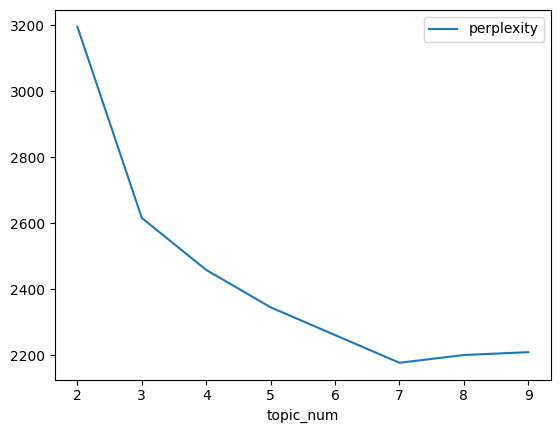

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

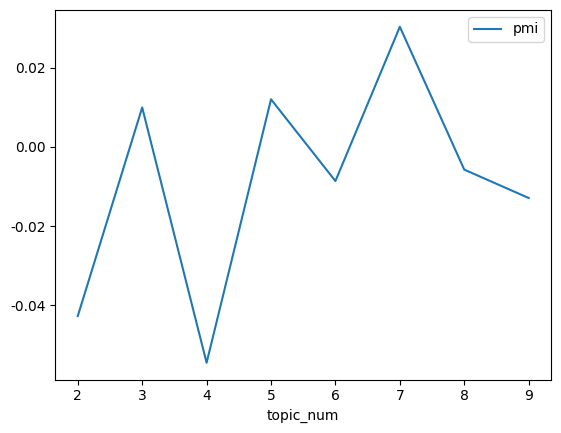

In [ ]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 7為最佳，coherence 最高也是7

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 8 來做 LDAvis 的結果範例

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.048735  0.173823       1        1  28.657381
4     -0.117134  0.071695       2        1  18.441704
6     -0.099626 -0.258605       3        1  17.656698
0     -0.203595 -0.110778       4        1  13.078667
1      0.292054 -0.101151       5        1  10.956295
3     -0.044256  0.194696       6        1   7.819196
5      0.221292  0.030320       7        1   3.390060, topic_info=     Term         Freq        Total Category  logprob  loglift
3251   股利  1679.000000  1679.000000  Default  30.0000  30.0000
318    累計  1216.000000  1216.000000  Default  29.0000  29.0000
152    盈餘  1125.000000  1125.000000  Default  28.0000  28.0000
1217   本期   992.000000   992.000000  Default  27.0000  27.0000
71     公司  2785.000000  2785.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
2659   標題   124.323068  1303.701910   Topic7  -4.8801   1.0342
1563   科技   105.736680   571.365123   Topic7  -5.0420   1.6972
7792   廣達    93.886165   337.790952   Topic7  -5.1609   2.1040
4133   上市    97.896589   520.739711   Topic7  -5.1190   1.7130
6395   網址    92.631931   662.772752   Topic7  -5.1743   1.4165

[537 rows x 6 columns], token_table=      Topic      Freq Term
term                      
589       1  0.032883   一下
589       2  0.420627   一下
589       3  0.016441   一下
589       4  0.523386   一下
589       5  0.004110   一下
...     ...       ...  ...
8834      7  0.438628   高息
7717      6  0.997133   鴻海
7998      2  0.032220   點數
7998      4  0.945129   點數
7998      6  0.010740   點數

[1394 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 7, 1, 2, 4, 6])

可以看到(2,1,6)很相近，試試看跑5個主題

In [ ]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.132764  0.056492       1        1  32.068120
0     -0.013621 -0.212234       2        1  24.987827
4      0.118970 -0.109539       3        1  23.225134
1     -0.337549  0.054321       4        1  12.891208
3      0.099436  0.210960       5        1   6.827710, topic_info=     Term         Freq        Total Category  logprob  loglift
318    累計  1363.000000  1363.000000  Default  30.0000  30.0000
3251   股利  1770.000000  1770.000000  Default  29.0000  29.0000
1217   本期  1128.000000  1128.000000  Default  28.0000  28.0000
71     公司  2790.000000  2790.000000  Default  27.0000  27.0000
152    盈餘  1245.000000  1245.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
7792   廣達   125.931731   308.979297   Topic5  -5.5673   1.7866
2659   標題   163.830908  1379.391494   Topic5  -5.3042   0.5536
8175   證券   140.478354   592.572432   Topic5  -5.4580   1.2448
195    開發   133.606317   461.183009   Topic5  -5.5082   1.4453
1563   科技   135.115623   604.699998   Topic5  -5.4969   1.1856

[406 rows x 6 columns], token_table=      Topic      Freq Term
term                      
589       1  0.033065   一下
589       2  0.443619   一下
589       3  0.520770   一下
589       4  0.001378   一下
589       5  0.001378   一下
...     ...       ...  ...
1343      2  0.814471   高鐵
1343      4  0.006186   高鐵
1343      5  0.084540   高鐵
7717      1  0.006106   鴻海
7717      5  0.989226   鴻海

[957 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])

替換主題數跑看看，可以看出最佳參數的數字和人類判斷的不一定會相符，所以為了更好的觀察文本中的資訊，逐步、循環的調整是很重要的

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.8` 可正常執行

In [ ]:
pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Cloning https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to /tmp/pip-install-3obe8iar/guidedlda_4d1a359615e047e09cd3785391cdb56d
  Running command git clone --filter=blob:none --quiet https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git /tmp/pip-install-3obe8iar/guidedlda_4d1a359615e047e09cd3785391cdb56d
  Resolved https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to commit 05c3bf2c18f9d126cc5170256f33e6c1fbc90052
  Preparing metadata (setup.py) ... done
  Created wheel for GuidedLDA: filename=guidedlda-2.0.0.dev31-cp310-cp310-linux_x86_64.whl size=2558687 sha256=765645cef4125be2fbf593e622f4c21ee621d55d4f4fe958af8511a184d6d90a
  Stored in directory: /tmp/pip-ephem-wheel-cache-5weta16i/wheels/2e/d3/0d/45d6ae01da5e14302f3f8e8260a78d13db2e37d72bae36c0cd
Successfully built GuidedLDA


In [ ]:
import guidedlda

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('不好意思', '來說', '優點', '兩個', '兩房', '兩房一廳', '出口', '前輩', '只能', '客廳')

In [ ]:
word2id = dictionary.token2id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
seed_topic_list = [
    ['房屋', '車位', '房價', '目前', '建物', '資訊', '現在', '房子', '格局', '建設', '本文', '實價'],
    ['優惠', '活動', '回饋', '使用', '價格', '時間', '特價', '會員', '看到', '點數', '今天', '便宜'],
    ['公司', '原文', '股利', '台灣', '累計', '市場', '億元', '標題', '投資', '今年', '現金', '盈餘']
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 房屋 車位 建物 資訊 格局 本文 實價 建設 登錄 物件
Topic 1: 現在 真的 目前 知道 問題 覺得 應該 房子 比較 一下
Topic 2: 累計 股利 公司 盈餘 本期 現金 元股 董事會 元月 股東
Topic 3: 原文 億元 今年 台灣 成長 去年 記者 標題 時間 發布
Topic 4: 公司 表示 台灣 原文 中國 美國 電價 政府 發展 記者
Topic 5: 市場 投資 股價 利率 指數 台股 股息 今年 資金 基金


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.148940  0.149070       1        1  23.341189
5     -0.066011  0.190219       2        1  20.221640
4      0.020071  0.112737       3        1  17.186398
0      0.312717 -0.227244       4        1  14.647190
3     -0.171889  0.060414       5        1  14.013015
2     -0.243828 -0.285196       6        1  10.590568, topic_info=     Term         Freq        Total Category  logprob  loglift
318    累計  1447.000000  1447.000000  Default  30.0000  30.0000
3251   股利  1555.000000  1555.000000  Default  29.0000  29.0000
739    原文  2112.000000  2112.000000  Default  28.0000  28.0000
1217   本期  1152.000000  1152.000000  Default  27.0000  27.0000
152    盈餘  1172.000000  1172.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
541    資訊   689.864832  1539.830090   Topic6  -4.3056   1.4423
2721   資本   442.275827   611.138691   Topic6  -4.7501   1.9218
1291   來源   469.231082   933.696846   Topic6  -4.6910   1.5571
7929   營收   448.265884   908.755957   Topic6  -4.7367   1.5385
2659   標題   430.295714  1278.361517   Topic6  -4.7776   1.1563

[451 rows x 6 columns], token_table=      Topic      Freq Term
term                      
589       1  0.891523   一下
589       2  0.108370   一下
1353      1  0.905870   一堆
1353      2  0.095355   一堆
1045      1  0.741668   一直
...     ...       ...  ...
1343      3  0.550039   高鐵
1343      4  0.413768   高鐵
1343      5  0.037165   高鐵
7717      5  1.000785   鴻海
7998      1  1.000749   點數

[826 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 5, 1, 4, 3])

## 改變了主題列表、將房產相關的詞彙放在一起，多了運輸相關的詞彙

In [133]:
seed_topic_list = [
    ['房屋', '車位', '房價', '目前', '資訊', '現在', '房子', '格局', '建設', '本文', '實價','買房','房價'],
    ['優惠', '活動', '回饋', '特價', '會員', '今天', '便宜','使用', '價格', '時間','看到', '點數'],
    ['公司', '原文', '股利', '台灣', '累計', '市場', '億元', '標題', '投資', '今年', '現金', '盈餘','股票','銀行'],
    ['交通','捷運','汽車','運輸']
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [134]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [135]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0: 房屋 車位 建物 資訊 格局 建設 本文 實價 登錄 物件
Topic 1: 現在 目前 真的 知道 問題 應該 貸款 覺得 房子 比較
Topic 2: 累計 股利 公司 盈餘 本期 現金 元股 董事會 元月 股東
Topic 3: 億元 今年 成長 原文 台灣 去年 營收 開發 伺服器 客戶
Topic 4: 原文 公司 表示 台灣 中國 美國 記者 市場 時間 指出
Topic 5: 市場 股價 投資 利率 指數 台股 股息 今年 股票 資金


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.050653  0.198438       1        1  25.326748
5      0.174737  0.105587       2        1  19.078087
4      0.072809  0.081807       3        1  17.436705
0     -0.385622  0.013555       4        1  14.734614
3      0.173652 -0.019589       5        1  12.766608
2      0.015076 -0.379797       6        1  10.657238, topic_info=     Term         Freq        Total Category  logprob  loglift
318    累計  1447.000000  1447.000000  Default  30.0000  30.0000
3251   股利  1555.000000  1555.000000  Default  29.0000  29.0000
1217   本期  1152.000000  1152.000000  Default  28.0000  28.0000
152    盈餘  1172.000000  1172.000000  Default  27.0000  27.0000
772    現金  1317.000000  1317.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
2721   資本   448.269229   611.127695   Topic6  -4.7429   1.9290
1291   來源   480.216436   933.687405   Topic6  -4.6741   1.5740
7929   營收   450.265930   908.736400   Topic6  -4.7385   1.5367
2362   金額   429.300575   859.820623   Topic6  -4.7862   1.5444
2659   標題   434.292326  1278.374844   Topic6  -4.7746   1.1593

[457 rows x 6 columns], token_table=      Topic      Freq Term
term                      
589       1  0.868347   一下
589       2  0.128590   一下
589       6  0.002890   一下
1353      1  0.912624   一堆
1353      2  0.088538   一堆
...     ...       ...  ...
3165      1  0.033522   高點
3165      2  0.967352   高點
7717      2  0.066232   鴻海
7717      5  0.934600   鴻海
7998      1  1.000673   點數

[833 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 5, 1, 4, 3])

In [ ]:
# udn.loc[udn['artCatagory']=='兩岸', "content"].to_csv("tmp.csv")
udn.loc[udn['artCatagory']=='兩岸', "words"].to_csv("words.csv")
udn.loc[udn['artCatagory']=='股市', "words"].to_csv("words_stock.csv")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
udn.loc[udn['artCatagory']=='兩岸', "words"].explode().value_counts().to_csv("words_count.csv")
udn.loc[udn['artCatagory']=='股市', "words"].explode().value_counts().to_csv("words_count_stock.csv")

## 7. 主題分佈的應用，搭配其他文章資訊

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics_doc[100]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.9287559), (4, 0.054842994)]

In [ ]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.98601699, 0.        , 0.        , 0.        , 0.        ],
       [0.77297533, 0.01821236, 0.17168507, 0.01880424, 0.01832297],
       [0.21131662, 0.05050683, 0.37543115, 0.32416055, 0.03858482],
       ...,
       [0.        , 0.        , 0.74439198, 0.25186259, 0.        ],
       [0.        , 0.        , 0.99123508, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.99668831]])

In [ ]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
udn['topic_label'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label
1    1832
5    1449
3     922
2     659
4     231
Name: count, dtype: int64

In [ ]:
udn.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,artUrl,artCatagory,artDate,words,topic_label
0,不好意思又來叨擾房版了目前有看到高雄兩個物件感覺各有勝負想詢問看看版上的意見兩者的總價室內坪...,https://www.ptt.cc/bbs/home-sale/M.1709223923....,home_sale,2024-03-01 00:25:19,"[不好意思, 叨擾, 房版, 目前, 看到, 高雄, 兩個, 物件, 感覺, 各有勝負, 詢...",1
1,請問各位先進冠德安沐居要每坪萬冠德大直綻每坪萬雖然都在捷運出口但也比周邊貴一些這個價錢是貴在品牌嗎,https://www.ptt.cc/bbs/home-sale/M.1709232819....,home_sale,2024-03-01 02:53:37,"[請問, 先進, 德安, 沐居要, 每坪, 萬冠德大直, 每坪, 捷運, 出口, 周邊, 一...",1
2,連結內文台灣金聯土地未運用有原因駁斥養地炒房說媒體報導具公股色彩的台灣金聯近年大舉在南台灣與...,https://www.ptt.cc/bbs/home-sale/M.1709249161....,home_sale,2024-03-01 07:25:58,"[連結, 文台, 灣金聯, 土地, 運用, 原因, 駁斥, 養地, 炒房, 說媒, 報導, ...",3
3,好房網重點縣市成交漲跌排行點選區域實價登錄趨勢年月重點縣市實價登錄漲跌排行新竹市萬坪桃園市萬...,https://www.ptt.cc/bbs/home-sale/M.1709251729....,home_sale,2024-03-01 08:08:47,"[房網, 重點, 縣市, 成交, 漲跌, 排行, 點選, 區域, 實價, 登錄, 趨勢, 重...",1
4,地範響出畫站次的在規任榭桃均桃參考這篇還在說沒發包出去桃地分好幾標分別發包了今年也安排很多標...,https://www.ptt.cc/bbs/home-sale/M.1709252693....,home_sale,2024-03-01 08:24:51,"[地範響, 出畫, 規任, 桃均桃, 參考, 這篇, 還在, 發包, 桃地分, 好幾, 分別...",1


In [ ]:
udn['artDate'] = pd.to_datetime(udn['artDate'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
udn['artDate'].dt.date

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       2024-03-01
1       2024-03-01
2       2024-03-01
3       2024-03-01
4       2024-03-01
           ...    
5097    2024-03-31
5098    2024-03-31
5099    2024-03-31
5100    2024-03-31
5101    2024-03-31
Name: artDate, Length: 5093, dtype: object

In [ ]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


artDate     topic_label
2024-03-01  1              0.369128
            5              0.275168
            3              0.187919
            2              0.100671
            4              0.067114
                             ...   
2024-03-31  1              0.427419
            5              0.258065
            3              0.225806
            4              0.048387
            2              0.040323
Name: proportion, Length: 155, dtype: float64

In [ ]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label,1,2,3,4,5
artDate,,,,,
2024-03-01,0.369128,0.100671,0.187919,0.067114,0.275168
2024-03-02,0.388889,0.111111,0.203704,0.009259,0.287037
2024-03-03,0.423529,0.082353,0.200000,0.011765,0.282353
2024-03-04,0.286550,0.099415,0.175439,0.076023,0.362573
2024-03-05,0.325967,0.171271,0.209945,0.060773,0.232044


## 計算不同時間段的主題比率

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


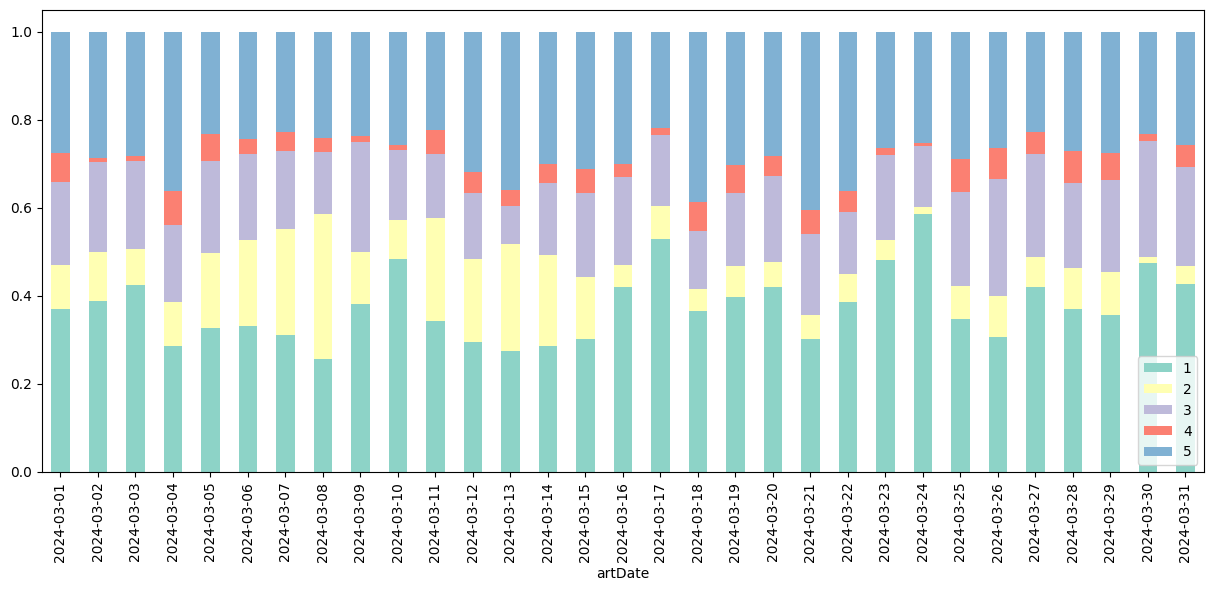

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

可以看到主題3（中國各產業市場）在 2/15、2/16 被討論的比例很高，可以作為後續探索的目標，<br>
大家可以像這樣，透過搭配文章的資訊（例如日期等），讓主題模型的結果做出更多的分析應用。